# Create dataset

In [2]:
from PIL import Image
import glob
import os.path
import re

base_dir = 'c:/clustering/dataset/' # images are expected to be in subfolders of this folder (no nested subfolders)
resized_suffix = '_resized'

size = (240, 240)
images = []
labels = []
for filename in glob.glob(base_dir + '*/*.jpg'):
    if resized_suffix in filename: continue # make sure we don't process the files we already resized
    resized_filename = os.path.splitext(filename)[0] + resized_suffix + '.jpg'
    if not os.path.isfile(resized_filename):
        image = Image.open(filename)
        image.thumbnail(size, Image.ANTIALIAS)
        image.save(resized_filename, "JPEG")
    images.append(Image.open(resized_filename))
    labels.append(re.split("[/\\\]", filename)[-2])

print("prepared " + str(len(images)) + " images")

prepared 243 images


# Extract Features

In [3]:
import numpy as np
X = np.ones(shape=(len(images), 0)) # initialize feature matrix X
X.shape

(243, 0)

## HSV histogram

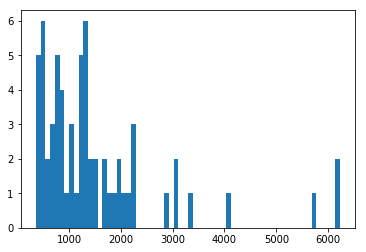

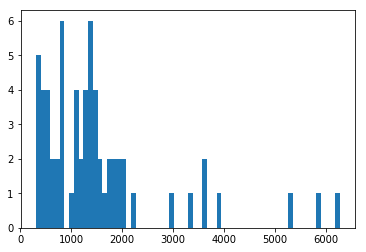

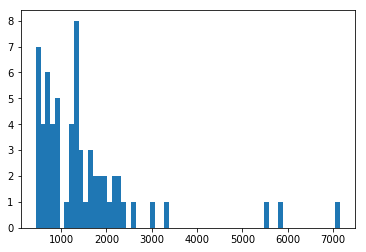

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

n_features = 64
features = np.zeros(shape=(len(images), n_features)) # initialize feature matrix

for i, image in enumerate(images):
    features[i] = np.histogram(image.convert('HSV'), bins=n_features)[0]
    if i < 3: 
        plt.hist(features[i], bins=n_features)
        plt.show()

X = np.column_stack((X, features)) # add new features to feature matrix X

## Edge histogram

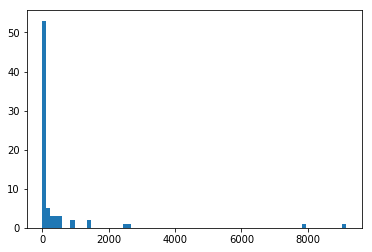

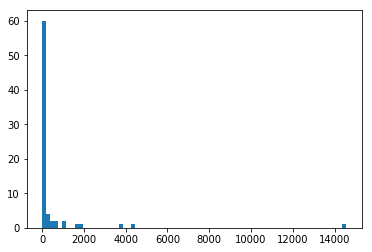

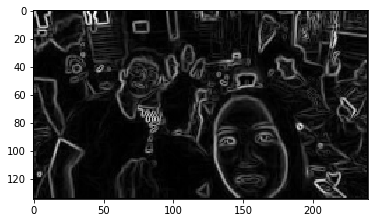

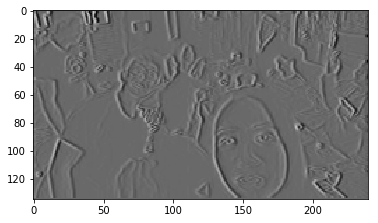

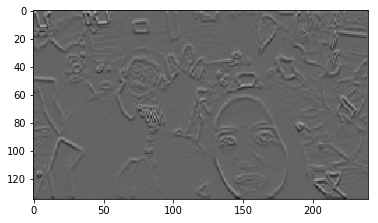

In [5]:
from skimage.filters import sobel
n_features = 75
features = np.ones(shape=(len(images), n_features*2)) # initialize feature matrix

for i, image in enumerate(images):
    edges = sobel(image.convert('HSV').getchannel('V'))
    grad_y, grad_x = np.gradient(edges)
    hist_x = np.histogram(grad_x, bins=n_features)[0]
    hist_y = np.histogram(grad_y, bins=n_features)[0]
    features[i] = np.append(hist_x, hist_y)
                            
    if i < 1:
        plt.figure()
        plt.hist(hist_x, bins=n_features)
        plt.figure()
        plt.hist(hist_y, bins=n_features)
        plt.figure()
        plt.imshow(edges, cmap='gray')
        plt.figure()
        plt.imshow(grad_x, cmap='gray')
        plt.figure()
        plt.imshow(grad_y, cmap='gray')

X = np.column_stack((X, features)) # add new features to feature matrix X

### Custom edge calculation

[[  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ... 180. 180.   0.]
 [  0.  90.  90. ... 135. 135.   0.]
 ...
 [  0.  90.  90. ...   0. 180.   0.]
 [  0.   0. 180. ...   0. 180.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]


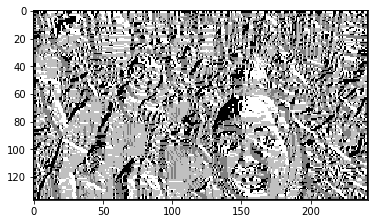

In [52]:
import math

for i, image in enumerate(images):
    grayscale = np.array(image.convert('L'))
    grayscale = np.pad(grayscale, 1, mode='constant') # surround with 0s to avoid out-of-bounds checks
    angles = np.zeros(grayscale.shape)
    magnitudes = np.zeros(grayscale.shape)
    for i in range(1, grayscale.shape[0] - 1):
        for j in range(1, grayscale.shape[1] - 1):
            mag = 0
            for ii in range(-1, 1):
                for jj in range(-1, 1):
                    if ii == jj == 0: next
                    if grayscale[i + ii, j + jj] > mag:
                        mag = grayscale[i + ii, j + jj]
                        mii = ii
                        mjj = jj
            ang = 0
            if (mii == -1):
                if   (mjj == -1): ang = 135
                elif (mjj == 0):  ang = 90
                elif (mjj == 1):  ang = 45
            elif (mii == 0):    
                if   (mjj == -1): ang = 180
                elif (mjj == 1):  ang = 0
            elif (mii == 1):
                if   (mjj == -1): ang = 225
                elif (mjj == 0):  ang = 270
                elif (mjj == 1):  ang = 315
                           
            angles[i, j]= ang
            magnitudes[i, j] = mag
    plt.figure()
    plt.imshow(angles, cmap='gray')
    print(angles)
    break
    
        

# K-means clustering

In [8]:
from sklearn.cluster import KMeans
import re, shutil

kmeans = KMeans(n_clusters=12, random_state=0).fit(X)

images_by_cluster = sorted(zip(images, kmeans.labels_), key=lambda x: x[1]) # create sorted list of (<image>, <cluster>) pairs

base_dir = 'c:/clustering/result/'
shutil.rmtree(base_dir)
for image, cluster in images_by_cluster: # save images in a directory per cluster
    cluster_dir = base_dir + str(cluster)
    if not os.path.exists(cluster_dir):
        os.makedirs(cluster_dir)
    image_name = cluster_dir + '/' + re.split("[/\\\]", image.filename)[-1]
    image.save(image_name, 'JPEG')


#kmeans.labels_
#kmeans.cluster_centers_


